<div align=center><img src="https://techinsight.com.cn/course/middleware_final.avif" width=40%></div>

# hooks的类型

如上图所示，LangChain提供了六个hooks来拦截请求，分别是before_agent、before_model、after_model、after_agent、wrap_tool_call、wrap_model_call，根据他们作用的位置不同，我们可以将他们分成两类。

## node节点的hook

在特定执行点按顺序运行，可用于日志记录、验证和状态更新。可用的hook包括以下4个，他们所接受的参数都相同：
- before_agent：智能体启动前触发（每次调用仅触发一次）
- before_model：每次调用模型前触发
- after_model：每次收到模型响应后触发
- after_agent：智能体完成执行后触发（每次调用仅触发一次）

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| `func` | Callable \| None | None | 要装饰的函数，必须接受 state: StateT, runtime: Runtime[ContextT] |
| `state_schema` | type \| None | None | 自定义状态模式类型。如果不提供，使用默认的 AgentState 模式 |
| `tools` | list[BaseTool] \| None | None | 要为此中间件注册的额外工具列表 |
| `can_jump_to` | list[JumpTo] \| None | None | 条件边的有效跳转目标。有效值：'tools'、'model'、'end' |
| `name` | str \| None | None | 生成的中间件类的可选名称。如果不提供，使用被装饰函数的名称 |


LangGraph处理state_shema参数的流程如下，强烈建议该shema与func的state参数类型一致：

## 包装式hook

可用的钩子有：
- wrap_model_call：拦截每次模型调用
- wrap_tool_call：拦截每次工具调用

wrap_model_call 参数

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| `func` | Callable \| None | None | 就是要装饰的中间件函数，接受 (request, handler)，调用 handler(request) 执行模型并返回 ModelResponse 或 AIMessage |
| `state_schema` | type \| None | None | 自定义状态模式。默认为 AgentState |
| `tools` | list[BaseTool] \| None | None | 为此中间件注册的额外工具列表 |
| `name` | str \| None | None | 中间件类名称。默认为函数名称 |

wrap_tool_call 参数

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| `func` | Callable \| None | None | 就是要装饰的中间件函数，函数接受 (request, handler)，调用 handler(request) 执行工具并返回 ToolMessage 或 Command |
| `tools` | list[BaseTool] \| None | None | 为此中间件注册的额外工具列表 |
| `name` | str \| None | None | 中间件类名称。默认为函数名称 |
| `state_schema` | - | - | ❌ 不支持此参数 |

主要区别

| 参数 | wrap_model_call | wrap_tool_call |
|------|---------------|---------------|
| `state_schema` | ✅ 支持 | ❌ 不支持 |
| `func` 签名 | (request, handler) → ModelResponse/AIMessage | (request, handler) → ToolMessage/Command |


## ModelRequest对象

`ModelRequest` 是一个`不可变`数据类，包含了调用模型时所需的所有信息。它主要用于 `wrap_model_call` 中间件，允许你拦截和修改模型调用。

### 属性

| 属性 | 类型 | 说明 |
|------|------|------|
| `model` | BaseChatModel | 要使用的聊天模型 |
| `messages` | list[AnyMessage] | 消息列表（不包括系统消息）, 从state中复制而来，需要通过override来创建新实例来改变|
| `system_message` | SystemMessage \| None | 系统消息实例 |
| `tool_choice` | Any \| None | 工具选择配置 |
| `tools` | list[BaseTool \| dict] | 可用工具列表 |
| `response_format` | ResponseFormat \| None | 响应格式规范 |
| `state` | AgentState | 代理状态 |
| `runtime` | Runtime[ContextT] | 运行时上下文 |
| `model_settings` | dict[str, Any] | 额外的模型设置 |


### 主要方法

 `override(**overrides) -> ModelRequest`

创建一个新的 `ModelRequest` 实例，用指定的属性替换原属性（不可变模式）。

**支持的覆盖参数**：
- `model`: BaseChatModel 实例
- `system_message`: SystemMessage 实例
- `messages`: 消息列表
- `tool_choice`: 工具选择配置
- `tools`: 可用工具列表
- `response_format`: 响应格式规范
- `model_settings`: 额外的模型设置

**示例**：

```python
# 更换模型
new_request = request.override(model=different_model)

# 覆盖系统消息（推荐方式）
new_request = request.override(
    system_message=SystemMessage(content="New instructions")
)

# 覆盖多个属性
new_request = request.override(
    model=ChatOpenAI(model="gpt-4o"),
    system_message=SystemMessage(content="New instructions"),
)
```


### 注意事项

- 直接属性赋值已被弃用，使用 `override()` 方法
- `override()` 返回新实例，原实例不变（不可变模式）
- `system_prompt` 已弃用，使用 `system_message` 代替

## ModelResponse对象

`ModelResponse` 是模型执行的响应，包含消息列表和可选的结构化输出。结果通常包含一个 `AIMessage`，如果定义了结构化输出，会包含额外的`structured_response`。


### 属性

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| `result` | list[BaseMessage] | - | 模型执行返回的消息列表，通常包含：`AIMessage`：模型的回复和`ToolMessage`（如果模型使用工具进行结构化输出） |
| `structured_response` | Any | None | 如果指定了 `response_format`，则是解析后的结构化输出，否则为 `None` |

### 使用示例

```python
# 基本使用
response = ModelResponse(
    result=[AIMessage(content="Hello world")],
    structured_response=None
)

# 带结构化输出
response = ModelResponse(
    result=[
        AIMessage(content="...", tool_calls=[...]),
        ToolMessage(content="...", tool_call_id="...")
    ],
    structured_response={"name": "John", "age": 30}
)

# 在中间件中修改响应
@wrap_model_call
def modify_response(request, handler):
    response = handler(request)
    ai_msg = response.result[0]
    return ModelResponse(
        result=[AIMessage(content=f"[{ai_msg.content}]")],
        structured_response=response.structured_response,
    )
```


### 类型别名

```python
ModelCallResult = ModelResponse | AIMessage
```

中间件可以返回完整的 `ModelResponse` 或简化的 `AIMessage`（会自动转换）。

# 定义中间件的两个方式

中间件有两种定义方法，一种是改写AgentMiddleware基类，另一只是通过装饰器来定义，除非是只需要单个钩子、无需复杂配置和快速原型开发，否则最好是使用基类改写。

## 通过装饰器定义

In [ ]:
from langchain.agents.middleware import before_model, after_model, AgentState
from langchain.messages import AIMessage
from langgraph.runtime import Runtime
from typing import Any


# 在模型调用之前执行，且允许直接跳转到名为 "end" 的节点
@before_model(can_jump_to=["end"])
def check_message_limit(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    # 检查消息历史长度是否达到限制（例如 50 条）
    if len(state["messages"]) >= 50:
        # 如果达到限制，返回一条提示消息，并指示流程跳转到结束节点
        return {
            "messages": [AIMessage("对话次数已达上限。")],
            "jump_to": "end"
        }
    # 如果未达到限制，返回 None，流程将继续正常执行
    return None

# 在模型调用之后执行
@after_model
def log_response(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    # 打印模型返回的最新消息内容
    print(f"模型返回: {state['messages'][-1].content}")
    # 返回 None，仅用于执行副作用（如打印日志），不修改状态
    return None

## 通过基类改写定义

AgentMiddleware基类

类属性

| 属性 | 类型 | 说明 |
|------|------|------|
| `state_schema` | type[StateT] | 传递给中间件节点的状态模式 |
| `tools` | list[BaseTool] | 中间件注册的额外工具 |

类方法

| 方法 | 参数 | 返回值 | 说明 |
|------|------|--------|------|
| `name` | - | str | 中间件实例名称，默认为类名 |
| `before_agent` | state: StateT, runtime: Runtime[ContextT] | dict[str, Any] \| None \| Command | 在代理执行开始前运行的逻辑。异步版本：`abefore_agent` |
| `after_agent` | state: StateT, runtime: Runtime[ContextT] | dict[str, Any] \| None \| Command | 在代理执行完成后运行的逻辑。异步版本：`aafter_agent` |
| `before_model` | state: StateT, runtime: Runtime[ContextT] | dict[str, Any] \| None \| Command | 在模型调用前运行的逻辑。异步版本：`abefore_model` |
| `after_model` | state: StateT, runtime: Runtime[ContextT] | dict[str, Any] \| None \| Command | 在模型调用后运行的逻辑。异步版本：`aafter_model` |
| `wrap_model_call` | request: ModelRequest, handler: Callable | ModelCallResult | 通过 handler 回调拦截和控制模型执行。异步版本：`awrap_model_call` |
| `wrap_tool_call` | request: ToolCallRequest, handler: Callable | ToolMessage \| Command | 拦截工具执行以实现重试、监控或修改响应。异步版本：`awrap_tool_call` |

In [ ]:
from langchain.agents.middleware import AgentState, AgentMiddleware
from typing_extensions import NotRequired
from typing import Any

# 自定义状态类，继承自 AgentState
# 添加了两个可选字段：模型调用计数和用户ID
class CustomState(AgentState):
    model_call_count: NotRequired[int]  # 非必需字段，用于统计调用次数
    user_id: NotRequired[str]           # 非必需字段，用于存储用户ID


# 自定义中间件类，继承自AgentMiddleware[CustomState]这个泛型类
class CallCounterMiddleware(AgentMiddleware[CustomState]):
    # 指定该中间件使用的状态模式
    state_schema = CustomState

    # 在模型调用之前执行的方法
    def before_model(self, state: CustomState, runtime) -> dict[str, Any] | None:
        # 获取当前的调用计数，如果不存在则默认为0
        count = state.get("model_call_count", 0)
        # 如果调用次数超过10次，强制结束流程
        if count > 10:
            return {"jump_to": "end"}
        # 否则继续正常流程
        return None

# 自定义状态

通过`state_schema`属性，中间件可以通过自定义属性扩展智能体的状态。这使得中间件能够：
- 跨执行过程跟踪状态：在整个智能体执行生命周期中维护计数器、标志位或其他持久化值
- 在钩子之间共享数据：在 before_model 和 after_model 之间，或不同中间件实例之间传递信息
- 实现横切关注点：在不修改核心智能体逻辑的前提下，添加诸如速率限制、使用量追踪、用户上下文或审计日志等功能
- 做出条件性决策：利用累积的状态来决定是否继续执行、跳转到不同的节点，或动态调整行为

In [74]:
from langchain_deepseek import ChatDeepSeek
from langchain.agents import create_agent
from langchain.messages import HumanMessage
from langchain.agents.middleware import AgentState, before_model, after_model
from langgraph.checkpoint.memory import InMemorySaver
from typing_extensions import NotRequired
from typing import Any
from langgraph.runtime import Runtime


model = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0.7
)

# 扩展默认的 AgentState，添加自定义字段
class CustomState(AgentState):
    model_call_count: int = 0  # 可选字段，用于记录模型调用次数
    user_id: NotRequired[str]           # 可选字段，用于存储用户ID


# 在模型调用前执行的中间件钩子
@before_model(state_schema=CustomState, can_jump_to=["end"])
def check_call_limit(state: CustomState, runtime: Runtime) -> dict[str, Any] | None:
    # 获取当前调用计数，若无则默认为0
    count = state.get("model_call_count", 0) + 1
    # 如果调用次数超过限制（10次），则终止流程
    if count > 2:
        print(f"用户 {state.get('user_id')} 调用{count}次，已超过限制")
        return {"jump_to": "end"}
    # 否则继续正常执行
    return None


# 在模型调用后执行的中间件钩子
@after_model(state_schema=CustomState)
def increment_counter(state: CustomState, runtime: Runtime) -> dict[str, Any] | None:
    # 将模型调用计数加1并更新状态
    return {"model_call_count": state.get("model_call_count", 0) + 1}


# 创建智能体实例
agent = create_agent(
    model=model,          # 指定大模型
    middleware=[check_call_limit, increment_counter], # 注册中间件钩子
    checkpointer=InMemorySaver(), # 启用内存检查点保存state
    tools=[],                # 暂未绑定工具
)

# 第一次调用
result = agent.invoke({
    "messages": [HumanMessage("Hello")],   # 输入消息   
    "user_id": "user-123",                 # 传入用户ID
},
    config={"thread_id": "thread-123" }
)

# 第二次调用
result = agent.invoke({
    "messages": [HumanMessage("Hello")],
    "user_id": "user-123", 
},
    config={"thread_id": "thread-123" }
)

# 第三次调用
result = agent.invoke({
    "messages": [HumanMessage("Hello")],
    "user_id": "user-123", 
},
    config={"thread_id": "thread-123" }
)

用户 user-123 调用3次，已超过限制


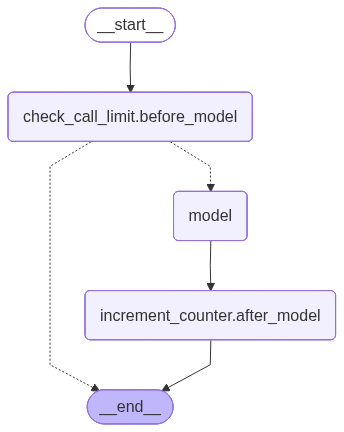

In [75]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# 节点跳跃

若要从中间件中提前退出，需要返回一个包含 jump_to 键的字典：
可用的跳转目标包括：
- end：跳转到智能体执行的末尾（或第一个 after_agent 钩子）
- tools：确保当AIMessage包含工具调用时才进行tools节点的跳转，否则即使跳转了也不会执行工具调用
- model：跳转到模型节点（或第一个 before_model 钩子）

In [78]:
from langchain_deepseek import ChatDeepSeek
from langchain.tools import tool, ToolRuntime
from langchain.agents import create_agent
from langchain.messages import HumanMessage, ToolMessage
from langchain.agents.middleware import AgentState, after_model, wrap_tool_call
from langchain.tools.tool_node import ToolCallRequest
from langgraph.types import Command
from langgraph.runtime import Runtime
from typing import Any, Callable


model = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0.7
)

class CustomState(AgentState):
    tool_call_count: int 

@tool
def get_weather(location: str, runtime: ToolRuntime) -> str:
    """获取当前天气及可选的预报信息。"""
    count = runtime.state.get("tool_call_count")
    if count == 1:
        result = f"网络连接失败，请重试"
    elif count == 2:
        result = f"网络连接失败，请重试"
    elif count == 3:
        result = f"{location}的天气是：22 摄氏度"
    return {
        "messages": [
            ToolMessage(
                content=result,
                tool_call_id=runtime.tool_call_id
            )
        ],
    }

@wrap_tool_call
def monitor_tool(
    request: ToolCallRequest,
    handler: Callable[[ToolCallRequest], ToolMessage | Command],
) -> ToolMessage | Command:
    print(f"Executing tool: {request.tool_call['name']}")
    print(f"Arguments: {request.tool_call['args']}")
    try:
        tool_result = handler(request)
        print(f"Tool completed successfully")
        return tool_result
    except Exception as e:
        print(f"Tool failed: {e}")
        raise

@after_model(state_schema=CustomState, can_jump_to=["tools","model","end"])
def count_tool_calls(state: CustomState, runtime: Runtime) -> dict[str, Any] | None:
    count = state.get("tool_call_count") + 1 
    if count == 4:
        print(f"Tool call count: {state.get("tool_call_count")}")
        return {
        "tool_call_count": count,
        "jump_to": "model"
    }
    elif count <=3:
        return {
            "tool_call_count": count,
            "jump_to": "tools"
        }
    else:
        return {
            "jump_to": "end"
        }

agent = create_agent(
    model,
    tools=[get_weather],
    state_schema=CustomState,
    system_prompt="你是一个天气查询助手，可以调用 get_weather 工具，遇到网络问题请重试，除非工具返回说超出调用限制",
    middleware=[count_tool_calls, monitor_tool],
)

for event in agent.stream({
    "messages": [HumanMessage(content="查询宁波的天气")],
    "tool_call_count": 0,
}, stream_mode="updates"):
    for step, data in event.items():
        print(step + ":", data)



model: {'messages': [AIMessage(content='我来帮您查询宁波的天气情况。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 334, 'total_tokens': 386, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 14}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '48e4fda0-21db-442c-9b1f-4fa3b85f8f12', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c38a5-d65b-7150-8840-c21829162176-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '宁波'}, 'id': 'call_00_DcnUyldoyUqqVqMVn2Yd2Yqe', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 334, 'output_tokens': 52, 'total_tokens': 386, 'input_token_details': {'cache_read': 320}, 'output_token_details': {}})]}
count_tool_calls.after_model: {'tool_call_count': 1, 'ju

# 中间件运行的顺序

为了更直观地理解，我们假设注册了三个中间件：[LoggerMiddleware(), AuthMiddleware(), RateLimitMiddleware()]，都定义了 before 和 after 钩子：

- before_* 钩子：从第一个中间件到最后一个依次执行（正序），即`A → B → C`
    - Logger 开始：记录“请求来了”。
    - Auth 开始：检查用户是否登录。
    - RateLimit 开始：检查是否超过调用频率。
- after_* 钩子：从最后一个中间件到第一个反向执行（逆序），即`C → B → A`
    - RateLimit 结束：记录调用次数。
    - Auth 结束：记录用户登录状态。
    - Logger 结束：记录“请求结束”。
- wrap_* 钩子：嵌套式调用，第一个中间件在外层，包裹后续所有中间件和最终的模型调用

 > 💡 这种设计类似于“洋葱模型”（Onion Model）或装饰器链：
wrap 钩子的执行顺序是 外→内（进入时），而 after 钩子则是 内→外（退出时），确保资源清理、日志记录等操作的正确配对。

# 官方案例

## 动态选择模型

In [ ]:
# 装饰器
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse
from langchain.chat_models import init_chat_model
from typing import Callable


complex_model = init_chat_model("gpt-4o")
simple_model = init_chat_model("gpt-4o-mini")

@wrap_model_call
def dynamic_model(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    # 根据消息列表的长度选择不同的模型
    if len(request.messages) > 10:
        model = complex_model
    else:
        model = simple_model
    return handler(request.override(model=model))

In [ ]:
# 类改写
from langchain.agents.middleware import AgentMiddleware, ModelRequest, ModelResponse
from langchain.chat_models import init_chat_model
from typing import Callable

complex_model = init_chat_model("gpt-4o")
simple_model = init_chat_model("gpt-4o-mini")

class DynamicModelMiddleware(AgentMiddleware):
    def wrap_model_call(
        self,
        request: ModelRequest,
        handler: Callable[[ModelRequest], ModelResponse],
    ) -> ModelResponse:
        # Use different model based on conversation length
        if len(request.messages) > 10:
            model = complex_model
        else:
            model = simple_model
        return handler(request.override(model=model))

## 工具调用监控

In [80]:
# 类改写，装饰器的案例在节点跳跃案例中有
from langchain.tools.tool_node import ToolCallRequest
from langchain.agents.middleware import AgentMiddleware
from langchain.messages import ToolMessage
from langgraph.types import Command
from typing import Callable

class ToolMonitoringMiddleware(AgentMiddleware):
    def wrap_tool_call(
        self,
        request: ToolCallRequest,
        handler: Callable[[ToolCallRequest], ToolMessage | Command],
    ) -> ToolMessage | Command:
        print(f"Executing tool: {request.tool_call['name']}")
        print(f"Arguments: {request.tool_call['args']}")
        try:
            result = handler(request)
            print(f"Tool completed successfully")
            return result
        except Exception as e:
            print(f"Tool failed: {e}")
            raise

## 动态选择工具

在运行时动态选择相关工具，以提升性能和准确性：
- 更短的提示（prompts）：仅暴露相关工具，降低提示复杂度
- 更高的准确性：模型在更少的选项中做出正确选择
- 权限控制：根据用户权限动态过滤可用工具

In [ ]:
# 装饰器
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse
from typing import Callable


@wrap_model_call
def select_tools(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    """Middleware to select relevant tools based on state/context."""
    # select_relevant_tools 是一个自定义函数，根据状态和运行时上下文选择相关工具
    relevant_tools = select_relevant_tools(request.state, request.runtime)
    return handler(request.override(tools=relevant_tools))

agent = create_agent(
    model="gpt-4o",
    tools=all_tools,  # 所有可用工具
    middleware=[select_tools],
)

In [ ]:
# 类改写
from langchain.agents import create_agent
from langchain.agents.middleware import AgentMiddleware, ModelRequest, ModelResponse
from typing import Callable


class ToolSelectorMiddleware(AgentMiddleware):
    def wrap_model_call(
        self,
        request: ModelRequest,
        handler: Callable[[ModelRequest], ModelResponse],
    ) -> ModelResponse:
        """Middleware to select relevant tools based on state/context."""
        relevant_tools = select_relevant_tools(request.state, request.runtime)
        return handler(request.override(tools=relevant_tools))

agent = create_agent(
    model="gpt-4o",
    tools=all_tools,  
    middleware=[ToolSelectorMiddleware()],
)

## 修改系统提示词

In [ ]:
# 装饰器
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse
from langchain.messages import SystemMessage
from typing import Callable


@wrap_model_call
def add_context(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    # 优先使用content_blocks
    new_content = list(request.system_message.content_blocks) + [
        {"type": "text", "text": "Additional context."}
    ]
    new_system_message = SystemMessage(content=new_content)
    return handler(request.override(system_message=new_system_message))

In [ ]:
# 类改写
from langchain.agents.middleware import AgentMiddleware, ModelRequest, ModelResponse
from langchain.messages import SystemMessage
from typing import Callable


class ContextMiddleware(AgentMiddleware):
    def wrap_model_call(
        self,
        request: ModelRequest,
        handler: Callable[[ModelRequest], ModelResponse],
    ) -> ModelResponse:
        # Always work with content blocks
        new_content = list(request.system_message.content_blocks) + [
            {"type": "text", "text": "Additional context."}
        ]
        new_system_message = SystemMessage(content=new_content)
        return handler(request.override(system_message=new_system_message))

# 最佳实践

- 保持中间件职责单一：每个中间件应专注于做好一件事。
- 优雅处理错误：不要让中间件中的错误导致整个智能体崩溃。
- 选用合适的钩子类型：
  - Node 风格适用于顺序逻辑（如日志记录、参数校验）
  - Wrap 风格适用于控制流操作（如重试、降级、缓存）
- 清晰文档化自定义状态属性：明确说明中间件新增或修改的状态字段。
- 独立单元测试中间件：在集成到智能体前，先对中间件进行单独测试。
- 注意执行顺序：将关键中间件放在中间件列表的靠前位置。
- 优先使用内置中间件：若框架已提供相应功能，应优先使用而非重复造轮子。